In [51]:
import pandas as pd
#df = pd.read_pickle("../cri_compustat_merged_v8.pkl")
#df.head()

In [2]:
from google.oauth2 import service_account
import pandas_gbq as gbq 
import json
from pandas_gbq import to_gbq, read_gbq

credentials_path = '../../token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [3]:
df_full = read_gbq(f"""

SELECT *
FROM capstone-402105.capstone.cri_compustat_data

""",project_id='capstone-402105', dialect='standard')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2155: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [37]:
# Unnecessary cols
labels_to_drop = [
    'CompNo',
    'year',
    'month',
    'gvkey',
    'tic',
    'dummy297fin',
    'StartDate'
]
df = df_full.drop(labels_to_drop, axis=1)
df.head()

,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,sizetrend,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,0.121681,-0.004016,10.636655,-0.719606,0.758769,0.157200,0.005983,-0.001407,1.900089,0.033246,...,255.207412,0.674972,137.826531,0.000000,1.000000,37.586070,-46.140794,-41.647642,-0.310145,10.860434
1,0.121681,-0.004016,4.596013,0.547466,0.280534,-0.039203,0.005733,-0.002453,0.650717,0.095478,...,0.000000,6.179372,126.818182,0.000000,1.000000,12.644176,-83.159927,-80.938732,-2.448988,16.706610
2,0.121681,-0.004016,9.608941,1.192495,3.512448,0.632913,0.004540,-0.002605,0.273628,0.085237,...,3119.717134,0.000000,192.272727,0.000000,1.000000,25.983451,-64.498429,-58.763662,-0.132720,1.007022
3,0.121681,-0.004016,9.269236,-6.134049,1.122227,-0.077907,0.008095,-0.002728,1.190292,0.008570,...,180.675805,1.260570,78.387097,0.322581,0.677419,28.939728,-61.798433,-60.044946,-0.493468,9.330209
4,0.121681,-0.004016,7.476566,0.400249,0.851392,-0.052482,0.005873,-0.000184,0.952575,0.019517,...,404.744047,0.849067,90.555556,0.238889,0.761111,36.829145,-52.108717,-48.761289,-0.554091,13.469110


In [38]:
df.dtypes

StkIndx                                    float64
STInt                                      float64
dtdlevel                                   float64
dtdtrend                                   float64
liqnonfinlevel                             float64
liqnonfintrend                             float64
ni2talevel                                 float64
ni2tatrend                                 float64
sizelevel                                  float64
sizetrend                                  float64
m2b                                        float64
sigma                                      float64
liqfinlevel                                float64
lqfintrend                                 float64
DTDmedianFin                               float64
DTDmedianNonFin                            float64
EventDate                      datetime64[ns, UTC]
Default_1                                    Int64
Default_3                                    Int64
Default_6                      

In [39]:
# Format Event Type col
#df = df[df['EventType'] != 2]
df['Default'] = df['Default_12'].apply(lambda x: '1' if x == 1 else '0')
df['Default'].value_counts()

0    1170064
1       9350
Name: Default, dtype: int64

In [40]:
labels_to_drop = [
    'Default_1', 
    'Default_3',
    'Default_6',
    'Default_24',
    'Default_36',
    'Default_60'
]
df = df.drop(labels_to_drop, axis=1)
df.head()

,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,sizetrend,...,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio,Default
0,0.121681,-0.004016,10.636655,-0.719606,0.758769,0.157200,0.005983,-0.001407,1.900089,0.033246,...,0.674972,137.826531,0.000000,1.000000,37.586070,-46.140794,-41.647642,-0.310145,10.860434,0
1,0.121681,-0.004016,4.596013,0.547466,0.280534,-0.039203,0.005733,-0.002453,0.650717,0.095478,...,6.179372,126.818182,0.000000,1.000000,12.644176,-83.159927,-80.938732,-2.448988,16.706610,0
2,0.121681,-0.004016,9.608941,1.192495,3.512448,0.632913,0.004540,-0.002605,0.273628,0.085237,...,0.000000,192.272727,0.000000,1.000000,25.983451,-64.498429,-58.763662,-0.132720,1.007022,0
3,0.121681,-0.004016,9.269236,-6.134049,1.122227,-0.077907,0.008095,-0.002728,1.190292,0.008570,...,1.260570,78.387097,0.322581,0.677419,28.939728,-61.798433,-60.044946,-0.493468,9.330209,0
4,0.121681,-0.004016,7.476566,0.400249,0.851392,-0.052482,0.005873,-0.000184,0.952575,0.019517,...,0.849067,90.555556,0.238889,0.761111,36.829145,-52.108717,-48.761289,-0.554091,13.469110,0


In [56]:
# Format Duration col
df['Duration'] = df['Duration'].astype(str)
df['Duration'] = df['Duration'].str.replace(r'\s', '', regex=True)
df['Duration'] = df['Duration'].str.split('days').str[0]
df['Duration'] = df['Duration'].astype('float32')

#Format Eventdate col
df['EventDate'] = pd.to_datetime(df['EventDate'])
df['EventDate'] = df['EventDate'].astype(int)

In [28]:
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
import numpy as np
import torchtuples as tt

In [57]:
# Split into train,test, validation
df_train = df
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
og_cols = df_train.columns.tolist()
cols_standardize = [i for i in og_cols if i not in ['Duration', 'Default']]
cols_leave =[]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [58]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [59]:
# Discretize time column
num_durations = 10

labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['Duration'].values, df['Default'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [60]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

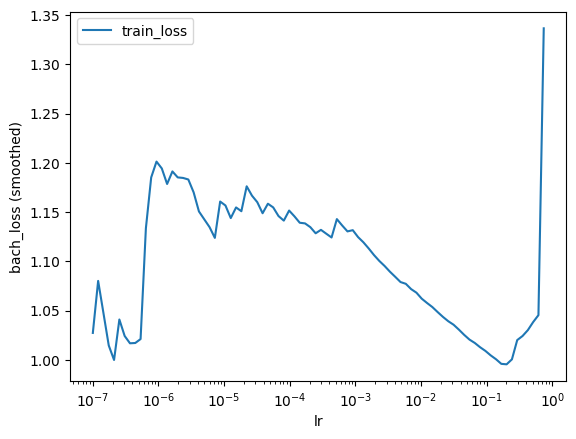

In [61]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [62]:
lr_finder.get_best_lr()

0.020092330025650584

In [63]:
model.optimizer.set_lr(0.01)

In [64]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[45s / 45s],		train_loss: 0.6181,	val_loss: 0.5872
1:	[42s / 1m:28s],		train_loss: 0.5915,	val_loss: 0.5857
2:	[46s / 2m:14s],		train_loss: 0.5863,	val_loss: 0.5799
3:	[44s / 2m:59s],		train_loss: 0.5837,	val_loss: 0.5786
4:	[42s / 3m:41s],		train_loss: 0.5816,	val_loss: 0.5775
5:	[40s / 4m:21s],		train_loss: 0.5801,	val_loss: 0.5732
6:	[40s / 5m:2s],		train_loss: 0.5791,	val_loss: 0.5775
7:	[40s / 5m:43s],		train_loss: 0.5786,	val_loss: 0.5731
8:	[40s / 6m:23s],		train_loss: 0.5783,	val_loss: 0.5721
9:	[40s / 7m:4s],		train_loss: 0.5776,	val_loss: 0.5684
10:	[40s / 7m:44s],		train_loss: 0.5770,	val_loss: 0.5723
11:	[41s / 8m:25s],		train_loss: 0.5765,	val_loss: 0.5704
12:	[41s / 9m:7s],		train_loss: 0.5763,	val_loss: 0.5674
13:	[41s / 9m:48s],		train_loss: 0.5759,	val_loss: 0.5713
14:	[41s / 10m:29s],		train_loss: 0.5757,	val_loss: 0.5647
15:	[40s / 11m:10s],		train_loss: 0.5756,	val_loss: 0.5687
16:	[41s / 11m:51s],		train_loss: 0.5753,	val_loss: 0.5754
17:	[42s / 12m:33s],		train

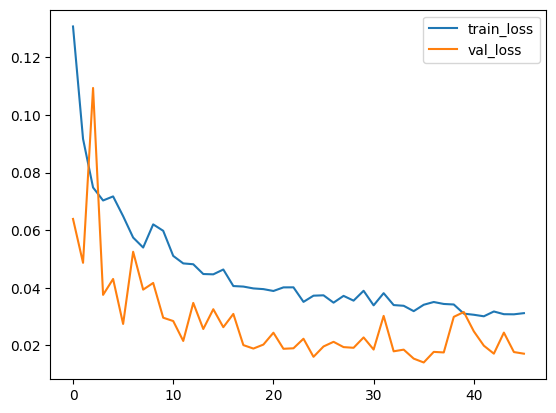

In [17]:
_ = log.plot()

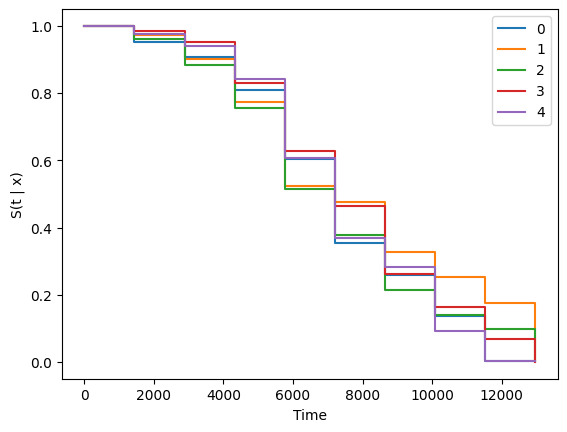

In [23]:
import matplotlib.pyplot as plt
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [24]:
surv = model.interpolate(10).predict_surv_df(x_test)

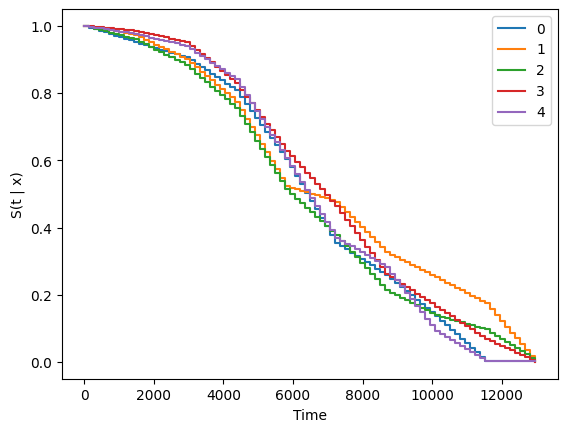

In [25]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

ROC AUC

In [65]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
surv = model.predict_surv_df(x_test)
surv.shape

(10, 235883)

In [66]:
test_pred = np.array(surv.iloc[9])
test_pred_binary = np.round(test_pred).astype(int)
test_true = df_test['Default'].to_numpy().astype(int)

In [67]:
accuracy = accuracy_score(test_true, test_pred_binary)
recall = recall_score(test_true, test_pred_binary)
precision = precision_score(test_true, test_pred_binary)
f1 = f1_score(test_true, test_pred_binary)
auc = roc_auc_score(df_test['Default'], test_pred)
confusion = confusion_matrix(test_true, test_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.992212240814302
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.6764333315434816


Concordance Index

In [68]:
ev = EvalSurv(surv, durations_test, events_test.astype(int), censor_surv='km')

In [ ]:
ev.concordance_td('antolini')